<img src='https://www.usc.gal/gl/info_xeral/imaxeusc/imaxes/001.gif'>

# Deep Learning
## Convolutional Neural Networks
### Age prediction

**Students**
- Victor Barreiro Dominguez
- Maximiliano Hormazábal Lagos 

In [11]:
## Code made for using the GPU

import tensorflow as tf
import numpy as np

np.random.seed(0)
tf.random.set_seed(0)

# Obtain the list of available devices
devices = tf.config.list_physical_devices('GPU')

if len(devices) > 0:
  # Set TensorFlow to use GPU
  tf.config.set_visible_devices(devices[0], 'GPU')
  print('GPU n°:', devices[0])
else:
  print('No GPU available.')

print("Current Device:", tf.test.gpu_device_name())

GPU n°: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Current Device: /device:GPU:0


2023-03-16 14:42:03.981607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 14:42:03.981698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 14:42:03.981740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 14:42:03.981805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 14:42:03.981846: I tensorflow/compiler/xla/stream_executo

# Loading data

In [12]:
# Dataset path
from os import listdir
import os.path

PATH = './faces_dataset_train/'
PATH_TEST = './faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

### Metadata access

In [13]:
import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


### Image reading

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Image shape:  (32, 32, 3)
Label:  20


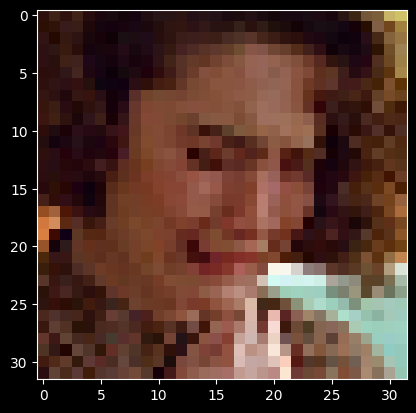

Image shape:  (32, 32, 3)
Label:  62


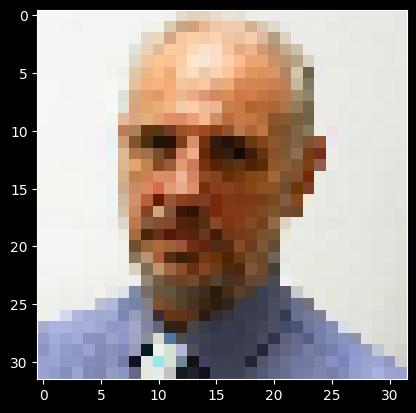

Image shape:  (32, 32, 3)
Label:  65


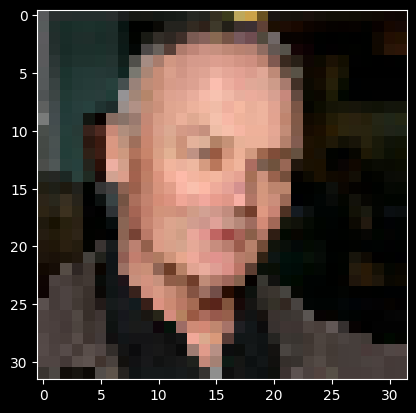

Image shape:  (32, 32, 3)
Label:  31


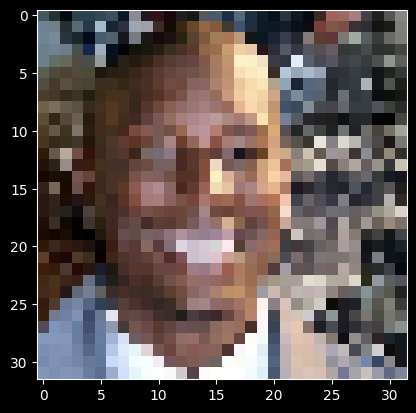

Image shape:  (32, 32, 3)
Label:  45


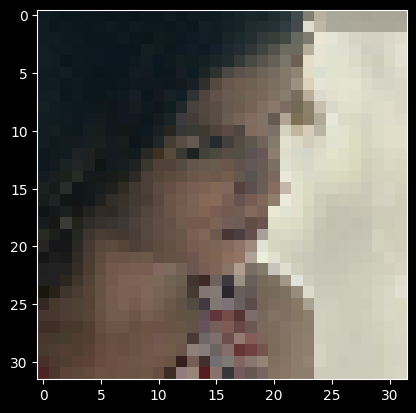

In [14]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import tensorflow as tf
from matplotlib import pyplot

# Size at which images will be processed
img_height = 32
img_width = 32

def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    age = parts[1]
    age = tf.strings.to_number(age, out_type=tf.dtypes.int32)
    gender = parts[2]
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, age


def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

# Checking
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    pyplot.imshow(image.numpy())
    pyplot.show()

In [15]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])

# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

# OPTIONAL: rescaled output to [0, 1]
# import numpy as np
# labels = [int(x.split('|')[1]) for x in train_metadata]
# max_age = tf.convert_to_tensor(np.max(labels), tf.float32)
# ds_train_transform = ds_train_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))
# ds_test_transform = ds_test_transform.map(lambda image, label: (image, tf.cast(label, tf.float32)/max_age))

# OPTIONAL: sample age weights
# import numpy as np
# step = 10
# labels = [int(x.split('|')[1]) for x in train_metadata]
# freqs, bins = np.histogram(labels, bins=list(range(0,100,step)) + [200])
# i_freqs = 1. / freqs
# sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
# print(sample_weights)
# ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))
# ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[tf.minimum(tf.cast(label, tf.int32) // step, len(i_freqs) - 1)]))

batch_size = 128
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

./faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M


# Funciones auxiliares

In [16]:
from keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import Input, Model
from keras.utils import plot_model

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np

dir = "models/"

def visualize_fit(history):
    """Procedure to print de evolution of a training process.

    Args:
        history (dict): _description_
    """    
    history_dict = history.history
    history_dict.keys()

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, 'b-o', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r-o', label='Validation loss')

    plt.title('Training and validation loss: MSE')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    acc = history_dict['mean_absolute_error']
    val_acc = history_dict['val_mean_absolute_error']

    plt.plot(epochs, acc, 'b-o', label='Training NAE')
    plt.plot(epochs, val_acc, 'r-o', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.ylim([0, 30])
    plt.legend()

    plt.tight_layout()
    plt.show()

def fitModel(model, ds_train, ds_val, num_epochs=20, monitor='val_mean_absolute_error', model_name='best_model.h5', callbacks=[]):
    checkpoint = ModelCheckpoint(dir + model_name, save_best_only=True, save_weights_only=False, monitor=monitor, mode='auto', verbose=1)
    history = model.fit(ds_train, verbose = 1, epochs=num_epochs, callbacks=callbacks+[checkpoint], validation_data=ds_val)
    result = model.evaluate(ds_val)
    print(result)
    visualize_fit(history)
    return result

# Modelos

### Final proposal

Our proposal in this case was to continue with what was done in the previous problem, for each model what we chose to do is to fine-tuning the whole feature extractor and replace the dense layers with new dense layers, train them. Once with this proposal in mind, we do a fine-tuning of the feature extractor instead of using it frozen. 

We keep as a relevant example a model in which we only introduce a final dense layer, on the case of the smaller model with the feature extractor frozen, we see how it manages to achieve good results despite this, although introducing the dense layers improved its performance (they can be uncommented if you want to check). We do it on this model because it showed the least interesting results of the comparison. 

#### The new dense layers
For the dense layers we used two layers with 16 and 8 units and normalization after each of them. We have tried using a larger number of layers and neurons but we have not obtained performance improvements and the impact on computational resources is very important.

#### The results

As expected, in general we noticed that the best performing networks are those on which we performed fine-tuning. In the same line, we confirm the hypothesis of the previous section, seeing that there is a greater difference between the models on this problem than on the previous one. We obtain the best results for the medium size model and doing fine-tuning. 

#### The cost function
We have tested both MSE and MAE, we have not obtained significant differences between them. As a final proposal we will use MSE as the cost function because it is more likely that in this way we will obtain a convex function, although it does not happen for any case. 

#### The hyperparameters 

In the same way as in the previous problem we have been testing and seeing the best behaviors for this final proposal, trying to make them similar for the models in order to show a certain comparison.

### Other tests

- More diverse designs: We have tested different designs, without including normalization, with a higher number of layers, different activation functions... As main conclusions, normalization tends to generate a more intuitive behavior in training and results. As for the number of layers and units per layer, we have not managed to improve the results shown here and, on the other hand, we have greatly increased the computational complexity of the model. The biggest difference was marked by the activation functions, the best combination being the relu activation functions and the linear to the final layer. We have also tested the sigmoid or relu on the final layer in the case of using normalized outputs without success and with clearly worse results with an MAE in validation of 22-25 years.

- Thawing more or less layers: We have performed some tests by thawing and keeping more or less layers of both the feature extractor and the general model, however, we have not improved the results reported here. Similarly, we did not find arguments of sufficient weight and that can be used on other problems for the choice of more or fewer layers with the proposed architecture.

## Small size

### Without fine-tuning

In [7]:
loaded_model = tf.keras.models.load_model(dir + "short_model.h5")
loaded_model.trainable =  False


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential



old_model = Sequential()
for layer in loaded_model.layers[:-1]:
    old_model.add(layer)
old_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 8)         216       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 8)        32        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 8)         576       
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 8)        32        
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 8)        0         
 ooling2D)                                                       
                                                        

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 8)         216       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 8)        32        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 8)         576       
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 8)        32        
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 8)        0         
 ooling2D)                                                       
                                                        

2023-03-16 12:41:44.213856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-16 12:41:44.626316: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 22/992 [..............................] - ETA: 2s - loss: 1672.6887 - mean_absolute_error: 38.5456   

2023-03-16 12:41:44.982665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-16 12:41:44.984409: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2016d3a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-16 12:41:44.984427: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-03-16 12:41:44.987282: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-16 12:41:45.021493: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 12:41:45.040661: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once f

984/992 [============================>.] - ETA: 0s - loss: 1640.4214 - mean_absolute_error: 38.0617
Epoch 1: val_mean_absolute_error improved from inf to 48.83621, saving model to models/short_age_freeze.h5
992/992 [==============================] - 4s 3ms/step - loss: 1640.5631 - mean_absolute_error: 38.0638 - val_loss: 3144.2710 - val_mean_absolute_error: 48.8362
Epoch 2/80
973/992 [============================>.] - ETA: 0s - loss: 1586.1158 - mean_absolute_error: 37.3395
Epoch 2: val_mean_absolute_error improved from 48.83621 to 48.11566, saving model to models/short_age_freeze.h5
992/992 [==============================] - 3s 3ms/step - loss: 1585.4904 - mean_absolute_error: 37.3332 - val_loss: 3074.3369 - val_mean_absolute_error: 48.1157
Epoch 3/80
978/992 [============================>.] - ETA: 0s - loss: 1532.1742 - mean_absolute_error: 36.6126
Epoch 3: val_mean_absolute_error improved from 48.11566 to 47.39997, saving model to models/short_age_freeze.h5
992/992 [================

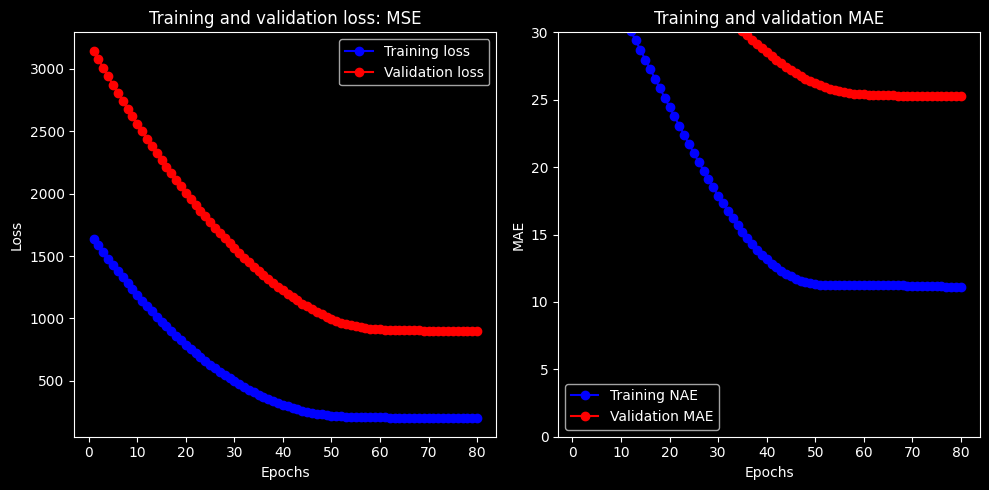

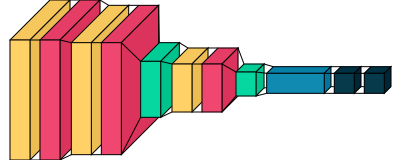

In [8]:
from tensorflow.keras.layers import Dense

new_model = tf.keras.models.clone_model(old_model)
#new_model.add(Dense(16, activation='relu', use_bias=False))
#new_model.add(tf.keras.layers.BatchNormalization(name="norm1"))
#new_model.add(Dense(8, activation='relu', use_bias=False))
#new_model.add(tf.keras.layers.BatchNormalization(name="norm2"))
new_model.add(Dense(1, activation='linear', name = 'Output_Layer'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

new_model.summary()
new_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])


fitModel(new_model, ds_train_batch, ds_test_batch, num_epochs=80, model_name='short_age_freeze.h5')

import visualkeras
visualkeras.layered_view(new_model)

In [17]:
loaded_model = tf.keras.models.load_model(dir + "short_age_freeze.h5")
loaded_model.evaluate(ds_test_batch)

8/8 [==============================] - 0s 5ms/step - loss: 897.9289 - mean_absolute_error: 25.2408


[897.9288940429688, 25.240785598754883]

### With fine-tuning

In [9]:
loaded_model = tf.keras.models.load_model(dir + "short_model.h5")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential

old_model = Sequential()
for layer in loaded_model.layers[:-2]:
    old_model.add(layer)
old_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 8)         216       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 8)        32        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 8)         576       
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 8)        32        
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 8)        0         
 ooling2D)                                                       
                                                      

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 8)         216       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 8)        32        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 8)         576       
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 8)        32        
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 8)        0         
 ooling2D)                                                       
                                                      

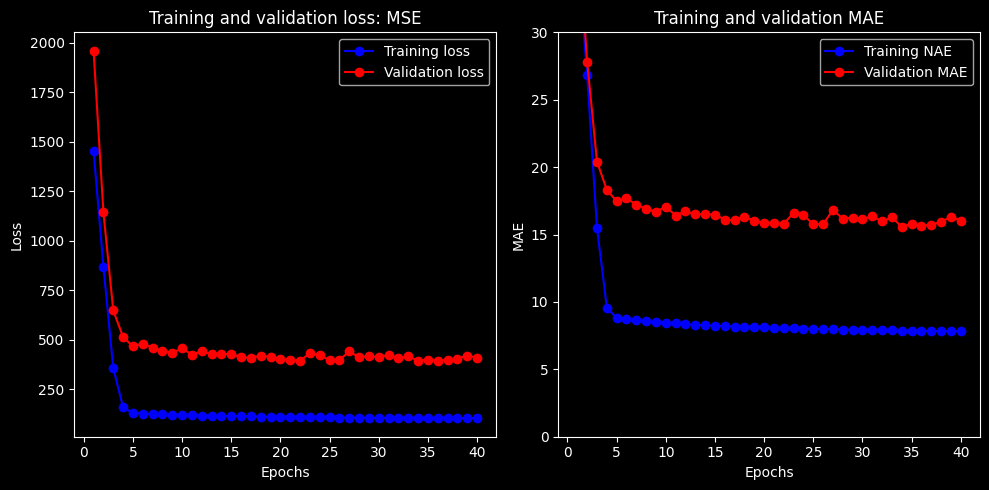

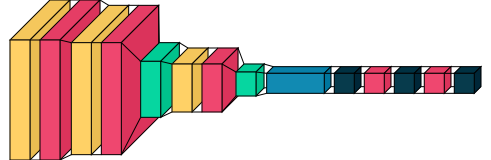

In [10]:
from tensorflow.keras.layers import Dense

new_model = tf.keras.models.clone_model(old_model)
new_model.add(Dense(16, activation='relu', use_bias=False))
new_model.add(tf.keras.layers.BatchNormalization(name="norm1"))
new_model.add(Dense(8, activation='relu', use_bias=False))
new_model.add(tf.keras.layers.BatchNormalization(name="norm2"))
new_model.add(Dense(1, activation='linear', name = 'Output_Layer'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

new_model.summary()
new_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])


fitModel(new_model, ds_train_batch, ds_test_batch, num_epochs=40, model_name='short_age_fine.h5')

import visualkeras
visualkeras.layered_view(new_model)

In [18]:
loaded_model = tf.keras.models.load_model(dir + "short_age_fine.h5")
loaded_model.evaluate(ds_test_batch)

8/8 [==============================] - 0s 5ms/step - loss: 392.7812 - mean_absolute_error: 15.5654


[392.78125, 15.565398216247559]

## Medium size

### Without fine-tuning

In [28]:
loaded_model = tf.keras.models.load_model(dir + "medium_model.h5")
loaded_model.trainable =  False


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential



old_model = Sequential()
for layer in loaded_model.layers[:-2]:
    old_model.add(layer)
old_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        864       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18432     
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 64)       0         
 ooling2D)                                                       
                                                      

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        864       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18432     
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 64)       0         
 ooling2D)                                                       
                                                      

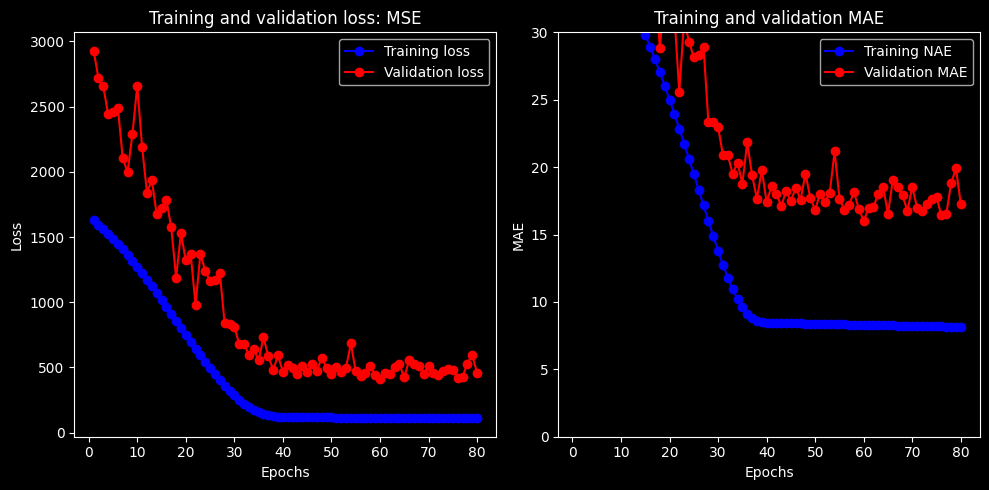

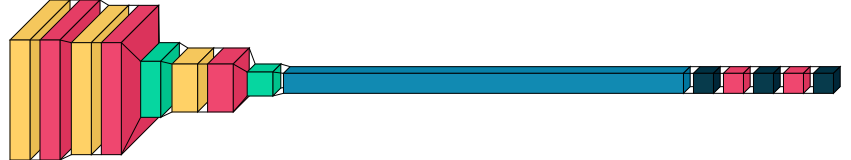

In [29]:
from tensorflow.keras.layers import Dense

new_model = tf.keras.models.clone_model(old_model)
new_model.add(Dense(16, activation='relu', use_bias=False))
new_model.add(tf.keras.layers.BatchNormalization(name="norm1"))
new_model.add(Dense(8, activation='relu', use_bias=False))
new_model.add(tf.keras.layers.BatchNormalization(name="norm2"))
new_model.add(Dense(1, activation='linear', name = 'Output_Layer'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

new_model.summary()
new_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])


fitModel(new_model, ds_train_batch, ds_test_batch, num_epochs=80, model_name='med_age_freeze.h5')

import visualkeras
visualkeras.layered_view(new_model)

In [19]:
loaded_model = tf.keras.models.load_model(dir + "med_age_freeze.h5")
loaded_model.evaluate(ds_test_batch)

8/8 [==============================] - 0s 9ms/step - loss: 415.2066 - mean_absolute_error: 16.0147


[415.2066345214844, 16.014673233032227]

### With fine-tuning

In [30]:
loaded_model = tf.keras.models.load_model(dir + "medium_model.h5")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential



old_model = Sequential()
for layer in loaded_model.layers[:-2]:
    old_model.add(layer)
old_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        864       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18432     
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 64)       0         
 ooling2D)                                                       
                                                      

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        864       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18432     
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 64)       0         
 ooling2D)                                                       
                                                      

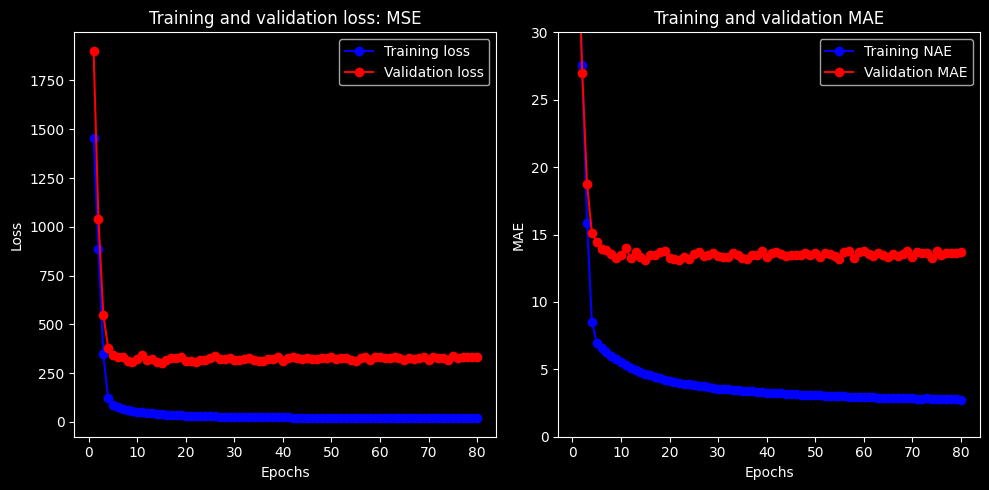

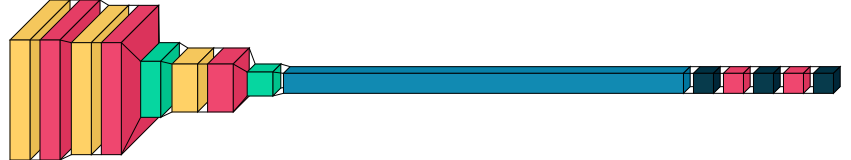

In [31]:
from tensorflow.keras.layers import Dense

new_model = tf.keras.models.clone_model(old_model)
new_model.add(Dense(16, activation='relu', use_bias=False))
new_model.add(tf.keras.layers.BatchNormalization(name="norm1"))
new_model.add(Dense(8, activation='relu', use_bias=False))
new_model.add(tf.keras.layers.BatchNormalization(name="norm2"))
new_model.add(Dense(1, activation='linear', name = 'Output_Layer'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

new_model.summary()
new_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])


fitModel(new_model, ds_train_batch, ds_test_batch, num_epochs=80, model_name='med_age_fine.h5')

import visualkeras
visualkeras.layered_view(new_model)

In [20]:
loaded_model = tf.keras.models.load_model(dir + "med_age_fine.h5")
loaded_model.evaluate(ds_test_batch)

8/8 [==============================] - 0s 5ms/step - loss: 299.8112 - mean_absolute_error: 13.0906


[299.8111572265625, 13.090620994567871]

## Big size

### Without fine-tuning

In [32]:
loaded_model = tf.keras.models.load_model(dir + "big_model.h5")
loaded_model.trainable =  False


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential



old_model = Sequential()
for layer in loaded_model.layers[:-2]:
    old_model.add(layer)
old_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       6912      
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 512)       1179648   
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 512)      2048      
 hNormalization)                                                 
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 512)      0         
 ePooling2D)                                                     
                                                      

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       6912      
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 512)       1179648   
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 512)      2048      
 hNormalization)                                                 
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 512)      0         
 ePooling2D)                                                     
                                                      

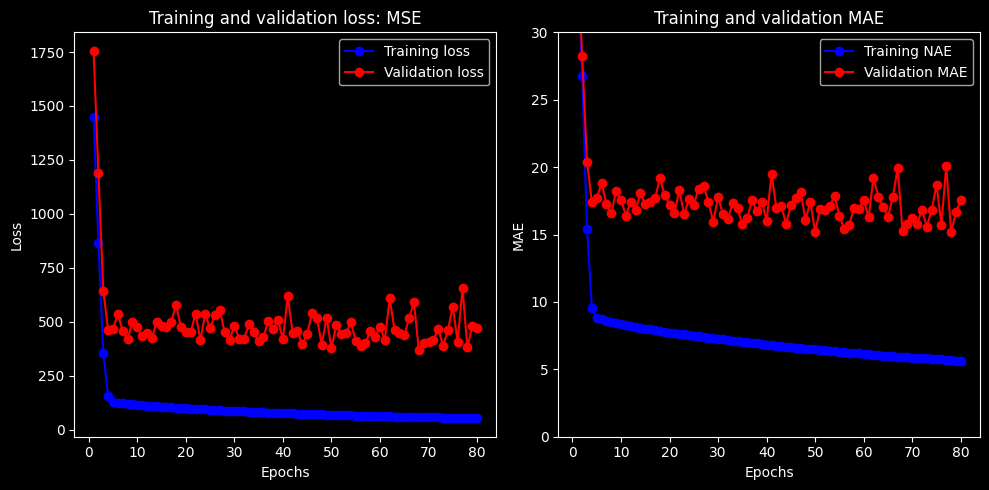

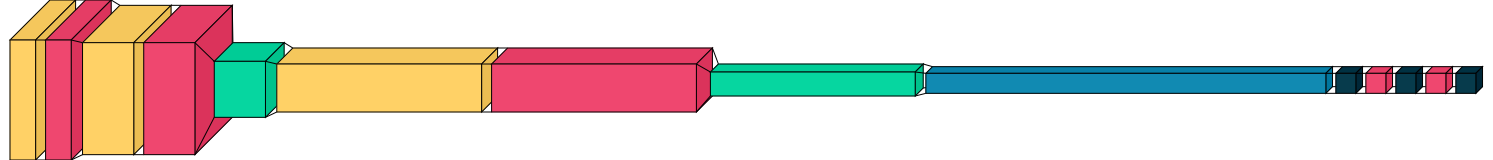

In [33]:
from tensorflow.keras.layers import Dense

new_model = tf.keras.models.clone_model(old_model)
new_model.add(Dense(16, activation='relu', use_bias=False))
new_model.add(tf.keras.layers.BatchNormalization(name="norm1"))
new_model.add(Dense(8, activation='relu', use_bias=False))
new_model.add(tf.keras.layers.BatchNormalization(name="norm2"))
new_model.add(Dense(1, activation='linear', name = 'Output_Layer'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

new_model.summary()
new_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])


fitModel(new_model, ds_train_batch, ds_test_batch, num_epochs=80, model_name='big_age_freeze.h5')

import visualkeras
visualkeras.layered_view(new_model)

In [21]:
loaded_model = tf.keras.models.load_model(dir + "big_age_freeze.h5")
loaded_model.evaluate(ds_test_batch)

8/8 [==============================] - 1s 78ms/step - loss: 382.1837 - mean_absolute_error: 15.1649


[382.1837158203125, 15.164867401123047]

### With fine-tuning

In [34]:
loaded_model = tf.keras.models.load_model(dir + "big_model.h5")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential



old_model = Sequential()
for layer in loaded_model.layers[:-2]:
    old_model.add(layer)
old_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       6912      
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 512)       1179648   
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 512)      2048      
 hNormalization)                                                 
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 512)      0         
 ePooling2D)                                                     
                                                      

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       6912      
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 512)       1179648   
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 512)      2048      
 hNormalization)                                                 
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 512)      0         
 ePooling2D)                                                     
                                                      

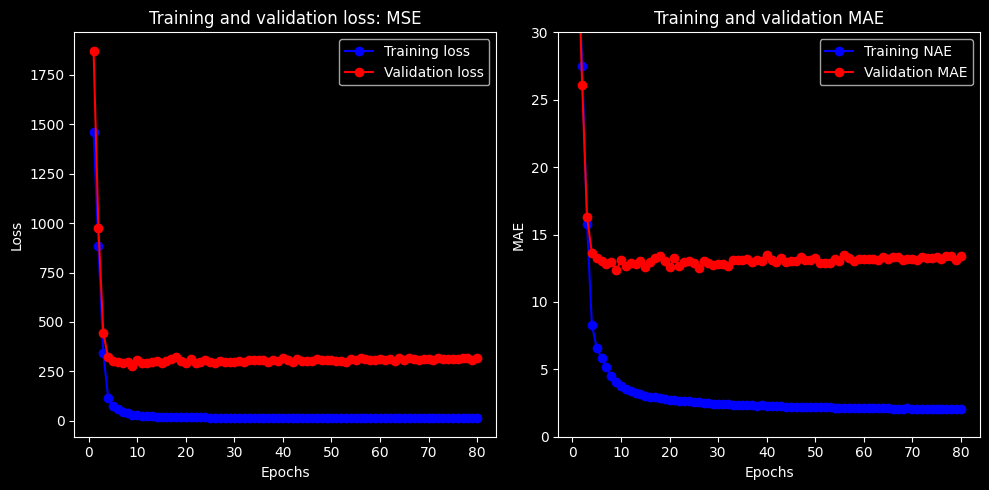

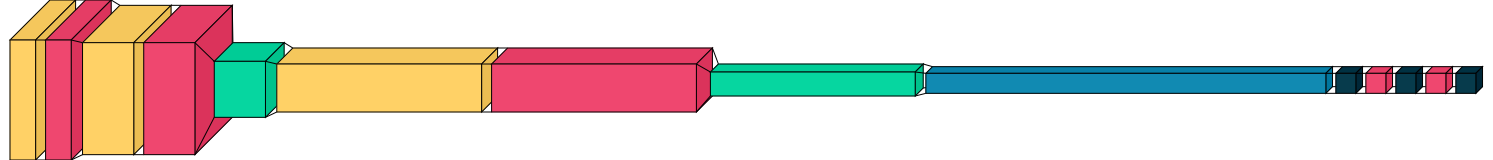

In [35]:
from tensorflow.keras.layers import Dense

new_model = tf.keras.models.clone_model(old_model)
new_model.add(Dense(16, activation='relu', use_bias=False))
new_model.add(tf.keras.layers.BatchNormalization(name="norm1"))
new_model.add(Dense(8, activation='relu', use_bias=False))
new_model.add(tf.keras.layers.BatchNormalization(name="norm2"))
new_model.add(Dense(1, activation='linear', name = 'Output_Layer'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

new_model.summary()
new_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])


fitModel(new_model, ds_train_batch, ds_test_batch, num_epochs=80, model_name='big_age_fine.h5')

import visualkeras
visualkeras.layered_view(new_model)

In [22]:
loaded_model = tf.keras.models.load_model(dir + "big_age_fine.h5")
loaded_model.evaluate(ds_test_batch)

8/8 [==============================] - 0s 18ms/step - loss: 278.4309 - mean_absolute_error: 12.3392


[278.4309387207031, 12.33919906616211]